<a href="https://colab.research.google.com/github/sravanisasu/BERT_Regression/blob/main/BERT_10K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup GPU**

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Extract data from github**

In [ ]:
!git clone https://github.com/sravanisasu/10k-sample

Cloning into '10k-sample'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9557 (delta 1), reused 1 (delta 0), pack-reused 9548
Receiving objects: 100% (9557/9557), 158.15 MiB | 21.18 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Checking out files: 100% (10020/10020), done.


**Required packages and imports**

In [ ]:
% pip install transformers

     |████████████████████████████████| 2.0MB 7.7MB/s 
     |████████████████████████████████| 3.2MB 27.0MB/s 
     |████████████████████████████████| 890kB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=0f2280351da0a9fe4407a133fcfdb8ee05da6df32b6c13c21dd9472f0c1619a4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import os as os
import regex as re
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from keras.models import Model
from keras import optimizers
from keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

**BERT Layer**

In [ ]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(module_url, trainable=False)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1, Total size: 423.26MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.


**Preprocessing the data**

In [ ]:
######## Function to extract the input text from the files ########
def process_inp_doc(path_file) :

  file_text = open(path_file,encoding='utf8').read()

  # remove punctations and digits and remove <PAGE> which was used for page number
  file_data = re.sub(r'[\d$%-:;!]', '', file_text)
  file_data = re.sub(r'<PAGE>', '', file_data)
  file_data = ''.join(file_data)

  return file_data

######## Function to extract the output values from the file ########
def process_out(company_id,output_file):
  
  with open(output_file,'r', encoding='utf-8') as m_file :
    for line in m_file.readlines():
      if company_id == line.split()[1]:
        return line.split()[0]
    print("not found")
  return None

######## Function to pre-process the documents from meta-file of a given year ########
def pre_processing(meta_file,output_file):
  
  with open(meta_file,'r', encoding='utf-8') as m_file :
    
    year = meta_file.split('/')[1].split('.')[0]
    dir_path = os.path.dirname(meta_file) + '/' +year+'.tok'
    data =[]
    for line in m_file.readlines():
      inp_path_file = dir_path +'/'+ line.split()[0] + '.mda'

      # get input sentences from the company document
      inp_sentences = process_inp_doc(inp_path_file)
    
      # get output value for the company
      out_values = float(process_out(line.split()[0],output_file))

      #insert values into the data list
      data.append({'text':inp_sentences,'value':out_values})

  return data

In [ ]:
######## Function to get the encoded values ######## 
def bert_encode(sentences, tokenizer, MAX_SEQ_LEN=512):

  all_tokens = []
  all_masks = []
  all_segments = []
  for sentence in sentences:
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[-MAX_SEQ_LEN+2:]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]

    token_ids = tokenizer.convert_tokens_to_ids(stokens,)

    ids = token_ids + [0] * (MAX_SEQ_LEN-len(token_ids))
    masks = [1]*len(token_ids) + [0] * (MAX_SEQ_LEN - len(token_ids))
    segments = [0] * (MAX_SEQ_LEN)

    all_tokens.append(ids)
    all_masks.append(masks)
    all_segments.append(segments)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
with tf.device('/device:GPU:0'):
  ######## extracting text and storing it in dataframes ########
  data_train = pre_processing('10k-sample/2007.meta.txt','10k-sample/2007.logvol.+12.txt')
  data_train.extend(pre_processing('10k-sample/2008.meta.txt','10k-sample/2008.logvol.+12.txt'))
  data_train.extend(pre_processing('10k-sample/2009.meta.txt','10k-sample/2009.logvol.+12.txt'))
  train_df = pd.DataFrame(data_train,columns=['text','value'])
  print("Length of training data",len(data_train))

  data_test = pre_processing('10k-sample/2010.meta.txt','10k-sample/2010.logvol.+12.txt')
  test_df = pd.DataFrame(data_test,columns=['text','value'])
  print("Length of testing data",len(data_test))

  print("SAMPLE INPUT TEXT AND VOLATILITY VALUES")
  print(train_df.sample(5)[['text','value']])
  print(test_df.sample(5)[['text','value']])

Length of training data 7571
Length of testing data 2439
SAMPLE INPUT TEXT AND VOLATILITY VALUES
                                                   text    value
7335  item # management s discussion and analysis of... -4.03576
7383  item # management s discussion and analysis of... -4.22553
6849  item # management s discussion and analysis of... -2.81352
4506  item # management s discussion and analysis of... -2.99594
715   item # management s discussion and analysis of... -2.79240
                                                   text    value
1689  item # management s discussion and analysis of... -3.50984
1987  item # management s discussion and analysis of... -3.90685
322   item # management s discussion and analysis of... -3.45968
416   item # management s discussion and analysis of... -3.51501
2208  item # management s discussion and analysis of... -3.81308


In [ ]:
train_df = train_df.loc[train_df["text"].apply(lambda x: x.split().__len__())>256]
print(train_df)
#88.7%
test_df = test_df.loc[test_df["text"].apply(lambda x: x.split().__len__())>256]
print(test_df)
#89.3%

                                                   text    value
0     item # management s discussion and analysis of... -3.46398
1     item # management s discussion and analysis of... -3.58048
2     item # management s discussion and analysis of... -3.87840
3     item # management s discussion and analysis of... -3.37969
4     item # management s discussion and analysis of... -4.34506
...                                                 ...      ...
7566  item # management s discussion and analysis of... -2.75096
7567  item # management s discussion and analysis of... -3.46372
7568  item # management s discussion and analysis of... -2.94439
7569  item # management s discussion and analysis of... -3.27556
7570  item # management s discussion and analysis of... -3.33055

[6717 rows x 2 columns]
                                                   text    value
0     item # management s discussion and analysis of... -3.87816
1     item # management s discussion and analysis of... -3.45482


In [ ]:
######## extracting tokens from dataframes ########
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

MAX_SEQ_LEN = 512

# with tf.device('/device:GPU:0'):
  
#### training 
# input encoding
sentences = train_df.text.values
bert_train_input = bert_encode(sentences, tokenizer, MAX_SEQ_LEN)
# output values
bert_train_output = train_df.value.values

#### test
# input encoding
sentences = test_df.text.values
bert_test_input = bert_encode(sentences, tokenizer, MAX_SEQ_LEN)
# output values
bert_test_output = test_df.value.values

In [ ]:
# output values
bert_train_output = train_df.value.values
# output values
bert_test_output = test_df.value.values
bert_train_output = np.array(bert_train_output).reshape(len(bert_train_output),1)
bert_test_output = np.array(bert_test_output).reshape(len(bert_test_output),1)


**Define the model**

In [ ]:
def get_model():

  input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

  custom_objects={'leaky_relu': tf.nn.leaky_relu}

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
  clf_output = pooled_output
  net = tf.keras.layers.Dense(64, activation=custom_objects['leaky_relu'])(clf_output)
  out = tf.keras.layers.Dense(1, activation=custom_objects['leaky_relu'], name='output')(net)

  model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

  opt = optimizers.Adam(learning_rate=0.1)
  model.compile(optimizer=opt, loss='mse')

  return model

In [ ]:
model = get_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

**Fit the model using KFold**

In [ ]:
n_splits = 5
epochs = 15
with tf.device('/device:GPU:0'):
  kf = KFold(n_splits=n_splits)
  history =[]
  train_loss=[]
  vald_loss=[]
  fold = 1
  for train_index, test_index in kf.split(bert_train_input[0]):
    
    checkpoint_filepath = 'Bert_results/CheckPoints/bert_checkpoint'+str(fold)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

    train_history = model.fit(
                              [bert_train_input[0][train_index],bert_train_input[1][train_index],bert_train_input[2][train_index]],#input
                              bert_train_output[train_index],#output
                              epochs=epochs, #epochs
                              verbose=1,
                              callbacks=[model_checkpoint_callback]
                          )
    model_best = tf.keras.models.load_model(checkpoint_filepath)
    fold+=1
    loss_T = model_best.evaluate([bert_train_input[0][train_index],bert_train_input[1][train_index],bert_train_input[2][train_index]]
                                        , bert_train_output[train_index], verbose=0)
    loss_V = model_best.evaluate([bert_train_input[0][test_index],bert_train_input[1][test_index],bert_train_input[2][test_index]]
                                      , bert_train_output[test_index], verbose=0)
    print(loss_T,loss_V)
    train_loss.append(loss_T)
    vald_loss.append(loss_V)
    history.append(train_history)

Epoch 1/15
168/168 [==============================] - 235s 1s/step - loss: 966.5560


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 2/15
168/168 [==============================] - 232s 1s/step - loss: 0.2670


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 3/15
168/168 [==============================] - 232s 1s/step - loss: 0.2601


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 4/15
168/168 [==============================] - 232s 1s/step - loss: 0.2496


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 5/15
168/168 [==============================] - 232s 1s/step - loss: 0.2521
Epoch 6/15
168/168 [==============================] - 232s 1s/step - loss: 0.2600


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint1/assets


Epoch 7/15
168/168 [==============================] - 232s 1s/step - loss: 0.2639
Epoch 8/15
168/168 [==============================] - 231s 1s/step - loss: 0.2507
Epoch 9/15
168/168 [==============================] - 232s 1s/step - loss: 0.2727
Epoch 10/15
168/168 [==============================] - 232s 1s/step - loss: 0.2682
Epoch 11/15
168/168 [==============================] - 232s 1s/step - loss: 0.2565
Epoch 12/15
168/168 [==============================] - 232s 1s/step - loss: 0.2537
Epoch 13/15
168/168 [==============================] - 232s 1s/step - loss: 0.2754
Epoch 14/15
168/168 [==============================] - 232s 1s/step - loss: 0.2784
Epoch 15/15
168/168 [==============================] - 232s 1s/step - loss: 0.3013
0.26673102378845215 0.408396452665329
Epoch 1/15
168/168 [==============================] - 232s 1s/step - loss: 0.2637


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint2/assets


Epoch 2/15
168/168 [==============================] - 232s 1s/step - loss: 0.2671
Epoch 3/15
168/168 [==============================] - 232s 1s/step - loss: 0.3141
Epoch 4/15
168/168 [==============================] - 232s 1s/step - loss: 0.3612
Epoch 5/15
168/168 [==============================] - 232s 1s/step - loss: 0.2962
Epoch 6/15
168/168 [==============================] - 232s 1s/step - loss: 0.2830
Epoch 7/15
168/168 [==============================] - 232s 1s/step - loss: 0.3505
Epoch 8/15
168/168 [==============================] - 232s 1s/step - loss: 0.3989
Epoch 9/15
168/168 [==============================] - 232s 1s/step - loss: 0.3047
Epoch 10/15
168/168 [==============================] - 232s 1s/step - loss: 0.3634
Epoch 11/15
168/168 [==============================] - 232s 1s/step - loss: 0.3451
Epoch 12/15
168/168 [==============================] - 232s 1s/step - loss: 0.3416
Epoch 13/15
168/168 [==============================] - 232s 1s/step - loss: 0.3001
Epoch 14/15


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


Epoch 2/15
168/168 [==============================] - 232s 1s/step - loss: 0.2972
Epoch 3/15
168/168 [==============================] - 232s 1s/step - loss: 0.3273
Epoch 4/15
168/168 [==============================] - 233s 1s/step - loss: 0.2966
Epoch 5/15
168/168 [==============================] - 232s 1s/step - loss: 0.2876
Epoch 6/15
168/168 [==============================] - 232s 1s/step - loss: 0.3050
Epoch 7/15
168/168 [==============================] - 232s 1s/step - loss: 0.2892
Epoch 8/15
168/168 [==============================] - 232s 1s/step - loss: 0.2712


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


Epoch 9/15
168/168 [==============================] - 233s 1s/step - loss: 0.2514


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


Epoch 10/15
168/168 [==============================] - 233s 1s/step - loss: 0.2692
Epoch 11/15
168/168 [==============================] - 232s 1s/step - loss: 0.2524
Epoch 12/15
168/168 [==============================] - 233s 1s/step - loss: 0.2385


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint3/assets


Epoch 13/15
168/168 [==============================] - 232s 1s/step - loss: 0.2517
Epoch 14/15
168/168 [==============================] - 233s 1s/step - loss: 0.2497
Epoch 15/15
168/168 [==============================] - 233s 1s/step - loss: 0.2395
0.2782061994075775 0.19748958945274353
Epoch 1/15
168/168 [==============================] - 233s 1s/step - loss: 0.2636


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint4/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint4/assets


Epoch 2/15
168/168 [==============================] - 232s 1s/step - loss: 0.2690
Epoch 3/15
168/168 [==============================] - 233s 1s/step - loss: 0.2664
Epoch 4/15
168/168 [==============================] - 233s 1s/step - loss: 0.2654
Epoch 5/15
168/168 [==============================] - 232s 1s/step - loss: 0.2650
Epoch 6/15
168/168 [==============================] - 232s 1s/step - loss: 0.2640
Epoch 7/15
168/168 [==============================] - 232s 1s/step - loss: 0.2690
Epoch 8/15
168/168 [==============================] - 232s 1s/step - loss: 0.2886
Epoch 9/15
168/168 [==============================] - 232s 1s/step - loss: 0.2594


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint4/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint4/assets


Epoch 10/15
168/168 [==============================] - 233s 1s/step - loss: 0.3080
Epoch 11/15
168/168 [==============================] - 233s 1s/step - loss: 0.3438
Epoch 12/15
168/168 [==============================] - 233s 1s/step - loss: 0.2602
Epoch 13/15
168/168 [==============================] - 233s 1s/step - loss: 0.2700
Epoch 14/15
168/168 [==============================] - 233s 1s/step - loss: 0.2609
Epoch 15/15
168/168 [==============================] - 233s 1s/step - loss: 0.2678
0.24335746467113495 0.22581346333026886
Epoch 1/15
168/168 [==============================] - 234s 1s/step - loss: 0.2702


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint5/assets


INFO:tensorflow:Assets written to: Bert_results/CheckPoints/bert_checkpoint5/assets


Epoch 2/15
168/168 [==============================] - 234s 1s/step - loss: 0.2863
Epoch 3/15
168/168 [==============================] - 233s 1s/step - loss: 0.2761
Epoch 4/15
168/168 [==============================] - 234s 1s/step - loss: 132170.9688
Epoch 5/15
168/168 [==============================] - 234s 1s/step - loss: 1305.4789
Epoch 6/15
168/168 [==============================] - 234s 1s/step - loss: 2.9349
Epoch 7/15
168/168 [==============================] - 234s 1s/step - loss: 1.4863
Epoch 8/15
168/168 [==============================] - 234s 1s/step - loss: 1.1290
Epoch 9/15
168/168 [==============================] - 234s 1s/step - loss: 0.9893
Epoch 10/15
168/168 [==============================] - 234s 1s/step - loss: 0.9057
Epoch 11/15
168/168 [==============================] - 234s 1s/step - loss: 0.8463
Epoch 12/15
168/168 [==============================] - 234s 1s/step - loss: 0.7998
Epoch 13/15
168/168 [==============================] - 234s 1s/step - loss: 0.7509
Epoc

**Plot the results**

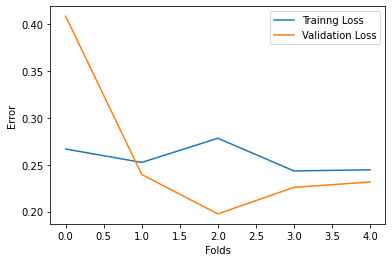

In [ ]:
plt.plot(train_loss, label = "Trainng Loss")
plt.plot(vald_loss, label = "Validation Loss")
# naming the x axis 
plt.xlabel('Folds') 
# naming the y axis 
plt.ylabel('Error') 
# function to show the plot 
plt.legend()
plt.savefig('Bert_results/Plots/bert_loss_check.png')

In [ ]:
test_loss = []
with tf.device('/device:GPU:0'):
  for i in range(n_splits):
    checkpoint_filepath = 'Bert_results/CheckPoints/bert_checkpoint'+str(i+1) 
    best_model = tf.keras.models.load_model(
                                            checkpoint_filepath, custom_objects=None, compile=True, options=None
                                            )
    predicted = best_model.predict(bert_test_input[0:50])
    
    loss_test = best_model.evaluate([bert_test_input[0],bert_test_input[1],bert_test_input[2]]
                                      , bert_test_output, verbose=0)
    print("Test Errror for the fold ",i+1," is",loss_test )
    
    
    plt.plot(predicted[0:50], label = "Predicted Values")  
    plt.plot(bert_test_output[0:50], label = "Actual Values")
    # naming the x axis 
    plt.xlabel('Test Samples') 
    # naming the y axis 
    plt.ylabel('Output Values') 
    # function to show the plot 
    plt.legend()
    textstr = "Test Errror for the fold "+ str(i+1)+" is "+str(np.round(loss_test,3))
    plt.gcf().text(0, -0.25, textstr, fontsize=14)
    plt.savefig('Bert_results/Plots/bert_fold'+str(i+1)+'.png',bbox_inches='tight')
    plt.clf()

    test_loss.append(loss_test)

Test Errror for the fold  1  is 0.5266319513320923


Training Loss: 0.257 (0.013)
Validation Loss: 0.261 (0.075)
Test Loss: 0.379 (0.101)


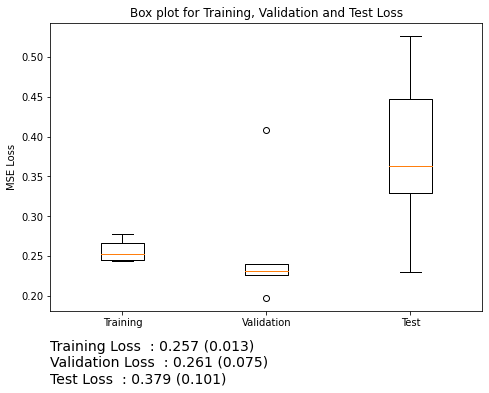

In [26]:
import matplotlib.pylab as plt
data=[]
data.append(train_loss)
data.append(vald_loss)
data.append(test_loss)
  
fig = plt.figure()  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
  
# Creating plot 
ax.boxplot(data)

ax.set_xticklabels(['Training', 'Validation','Test']) 

# naming the y axis 
plt.ylabel('MSE Loss')
plt.title("Box plot for Training, Validation and Test Loss")
textstr ='Training Loss  : '+str(np.round(np.mean(train_loss),3))+' ('+str(np.round(np.std(train_loss),3))+')\n'+'Validation Loss  : '+str(np.round(np.mean(vald_loss),3))+' ('+str(np.round(np.std(vald_loss),3))+')\n'+'Test Loss  : '+str(np.round(np.mean(test_loss),3))+' ('+str(np.round(np.std(test_loss),3))+')'
plt.gcf().text(0, -0.25, textstr, fontsize=14)
# show plot 
plt.savefig('Bert_results/Plots/block_bert.png',bbox_inches='tight')

print('Training Loss: %.3f (%.3f)' % (np.mean(train_loss), np.std(train_loss)))
print('Validation Loss: %.3f (%.3f)' % (np.mean(vald_loss), np.std(vald_loss)))
print('Test Loss: %.3f (%.3f)' % (np.mean(test_loss), np.std(test_loss)))

In [ ]:
!zip -r /content/file.zip /content/Bert_results
from google.colab import files
files.download("/content/file.zip")